In [1]:
print("Hello jupyter!")

Hello jupyter!


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [10]:
# Download the dataset
# dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
dataframe = pd.read_csv("./testDataset.csv")
dataframe = dataframe.drop(columns=['Unnamed: 0'])
raw_data = dataframe.values
dataframe.head()


,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0.794762,1.000000,0.840942,0.365378,0.000000,0.027210,0.136703,0.229776,0.291519,0.319606,...,0.292172,0.293538,0.295925,0.298311,0.300698,0.303084,0.292335,0.292090,0.400155,0.609146
1,0.991416,1.000000,0.575787,0.162458,0.000000,0.096570,0.178795,0.251411,0.306163,0.337870,...,0.304114,0.306260,0.306627,0.311499,0.316797,0.314168,0.301291,0.318692,0.465548,0.655788
2,1.000000,0.939139,0.422541,0.025000,0.000000,0.085656,0.163115,0.231148,0.281967,0.309426,...,0.250820,0.248566,0.250410,0.254098,0.257787,0.259836,0.259836,0.250615,0.265164,0.291393
3,0.726742,0.998497,1.000000,0.570140,0.052659,0.000000,0.112619,0.208401,0.276694,0.317713,...,0.284769,0.288807,0.289322,0.289580,0.294133,0.296581,0.290095,0.282751,0.359162,0.495232
4,0.923819,1.000000,0.581141,0.160807,0.000000,0.099391,0.193228,0.271650,0.316979,0.335497,...,0.303535,0.304493,0.305335,0.307576,0.309817,0.312057,0.310774,0.301927,0.335172,0.419779


In [6]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)



In [8]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


In [9]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]


In [11]:
print(len(normal_train_data))
print(len(anomalous_train_data))

2359
1639


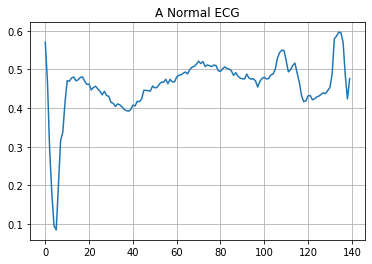

In [12]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

In [14]:
# Build the model
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')



In [15]:
# Train the model
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)


Epoch 1/20
5/5 [==============================] - 0s 28ms/step - loss: 0.0586 - val_loss: 0.0537
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0570 - val_loss: 0.0527
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0557 - val_loss: 0.0515
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0540 - val_loss: 0.0497
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0508 - val_loss: 0.0483
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0469 - val_loss: 0.0466
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0425 - val_loss: 0.0439
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0384 - val_loss: 0.0423
Epoch 9/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0349 - val_loss: 0.0405
Epoch 10/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0318 - val_loss: 0.0393
Epoch 11/20
5/5 [=====================

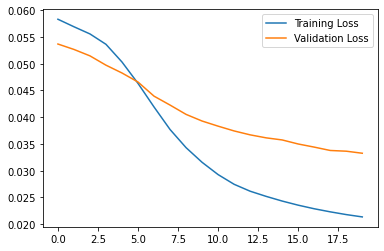

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

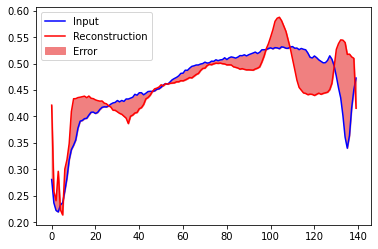

In [22]:
# Plot an anomalous #example:

encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

test_ind = 10
plt.plot(anomalous_test_data[test_ind], 'b')
plt.plot(decoded_imgs[test_ind], 'r')
plt.fill_between(np.arange(140), decoded_imgs[test_ind], anomalous_test_data[test_ind], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


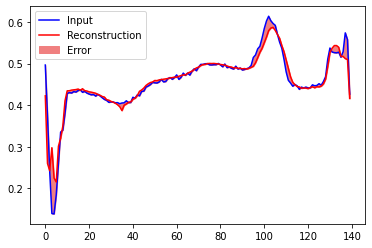

In [24]:
# Plot a normal example:

encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[5], 'b')
plt.plot(decoded_imgs[5], 'r')
plt.fill_between(np.arange(140), decoded_imgs[5], normal_test_data[5], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


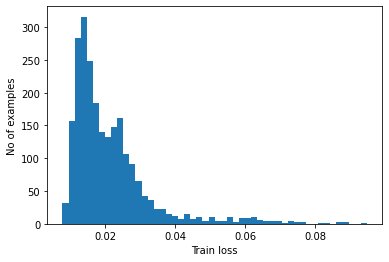

In [36]:
# Plot the reconstruction error on normal data

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data).numpy()
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


In [37]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.03266422


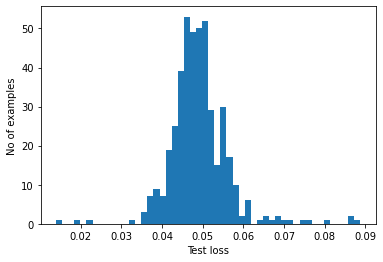

In [38]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data).numpy()

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [39]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))


In [40]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)


Accuracy = 0.942
Precision = 0.9921568627450981
Recall = 0.9035714285714286
